In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.utils.data import DataLoader

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_NN
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights
from data_gen import get_classification_data, ClassificationDataSet

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Classification on a toy dataset

In [2]:
(X, y), X_test = get_classification_data()

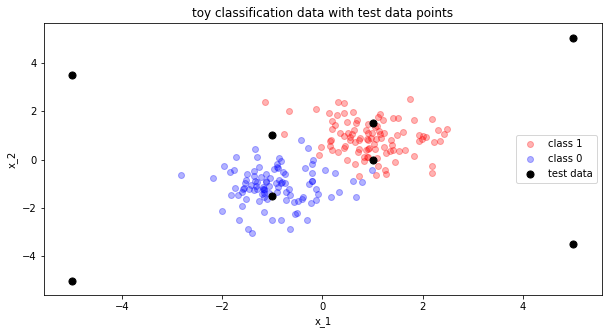

In [3]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [4]:
# Take a look at the architecture of Classification_NN
Classification_NN()

Classification_NN(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2, bias=True)
)

In [17]:
# Initialize SWAG
swag = SWAG(Classification_NN, K = 5)
print("Total number of parameters for the NN is:", swag.weigt_D)

Total number of parameters for the NN is: 28


In [18]:
# Compile swag
objective = 'classification'
lr = 1e-3
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = CosineAnnealingLR
swa_scheduler = LambdaLR

swag.compile(objective, lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

In [19]:
# Initialize the DataSet
train_data = ClassificationDataSet(n_samples=1000, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 16, shuffle = False)

(1000, 2) (1000, 1)


In [20]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=50,
                                    swag_epoch=20,
                                    log_freq=60)

Begin NN model training:
[Epoch: 1, Iteration:    60] Training Loss: 0.7322
[Epoch: 2, Iteration:    60] Training Loss: 0.7140
[Epoch: 3, Iteration:    60] Training Loss: 0.7094
[Epoch: 4, Iteration:    60] Training Loss: 0.7060
[Epoch: 5, Iteration:    60] Training Loss: 0.7018
[Epoch: 6, Iteration:    60] Training Loss: 0.6963
[Epoch: 7, Iteration:    60] Training Loss: 0.6887
[Epoch: 8, Iteration:    60] Training Loss: 0.6789
[Epoch: 9, Iteration:    60] Training Loss: 0.6677
[Epoch: 10, Iteration:    60] Training Loss: 0.6544
[Epoch: 11, Iteration:    60] Training Loss: 0.6389
[Epoch: 12, Iteration:    60] Training Loss: 0.6213
[Epoch: 13, Iteration:    60] Training Loss: 0.6025
[Epoch: 14, Iteration:    60] Training Loss: 0.5832
[Epoch: 15, Iteration:    60] Training Loss: 0.5645
[Epoch: 16, Iteration:    60] Training Loss: 0.5465
[Epoch: 17, Iteration:    60] Training Loss: 0.5295
[Epoch: 18, Iteration:    60] Training Loss: 0.5135
[Epoch: 19, Iteration:    60] Training Loss: 0.4

In [21]:
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], first_mom, second_mom, D, S=5, expanded=True)
expand_pred

array([[[9.98366773e-01, 1.63319160e-03],
        [9.72748220e-01, 2.72517521e-02],
        [1.79496151e-08, 1.00000000e+00],
        [3.52059811e-04, 9.99647975e-01],
        [8.04200888e-01, 1.95799112e-01],
        [9.41228032e-01, 5.87720498e-02],
        [7.31467549e-03, 9.92685318e-01],
        [4.62485515e-02, 9.53751385e-01]],

       [[1.00000000e+00, 6.85609555e-12],
        [9.80452657e-01, 1.95473805e-02],
        [7.68637732e-19, 1.00000000e+00],
        [1.24599628e-01, 8.75400364e-01],
        [1.02773502e-01, 8.97226453e-01],
        [9.99897242e-01, 1.02699509e-04],
        [1.74965328e-06, 9.99998212e-01],
        [1.14729337e-03, 9.98852730e-01]],

       [[9.99988198e-01, 1.17489590e-05],
        [9.90141690e-01, 9.85837542e-03],
        [7.84627658e-12, 1.00000000e+00],
        [9.22425301e-04, 9.99077559e-01],
        [7.08448946e-01, 2.91550994e-01],
        [9.88181412e-01, 1.18185487e-02],
        [5.56374667e-04, 9.99443591e-01],
        [1.42881582e-02, 9.857

In [22]:
swag.predict(torch.Tensor(X_test), [0, 1], first_mom, second_mom, D, S=5)

array([0, 0, 1, 1, 0, 0, 1, 1])